# Instructions
- Some parts of the code are already done for you
- You need to execute all the cells
- You need to add the code where ever you see `"#### Add your code here ####"`
- Marks are mentioned along with the cells

# Face detection
Task is to predict the boundaries(mask) around the face in a given image.

## Dataset
Faces in images marked with bounding boxes. Have around 500 images with around 1100 faces manually tagged via bounding box.

### Mount Google drive if you are using google colab
- We recommend using Google Colab as you can face memory issues and longer runtimes while running on local

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### Change current working directory to project folder (1 mark)

In [0]:
import os
os.getcwd()
os.chdir("/content/drive/My Drive/ML_Project/Face detection")

### Load the "images.npy" file (4 marks)
- This file contains images with details of bounding boxes

In [5]:
import numpy as np
from matplotlib import pyplot as plt
import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.layers import Concatenate,Conv2D,Reshape,UpSampling2D
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras import Model
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.backend import log, epsilon
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


data = np.load('images.npy', allow_pickle=True)
print(data.shape)
print((data[0][0]).shape)

(409, 2)
(333, 650, 3)


### Check one sample from the loaded "images.npy" file  (4 marks)

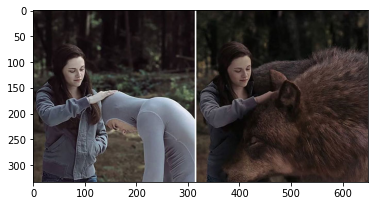

In [5]:
plt.imshow(data[0][0])
plt.show()

### Set image dimensions   (2 marks)
- Initialize image height, image width with value: 224 

In [0]:
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224

### Create features and labels
- Here feature is the image
- The label is the mask
- Images will be stored in "X_train" array
- Masks will be stored in "masks" array

In [0]:
import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input

masks = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH))
X_train = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH, 3))
for index in range(data.shape[0]):
    img = data[index][0]
    img = cv2.resize(img, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=cv2.INTER_CUBIC)
    try:
      img = img[:, :, :3]
    except:
      continue
    X_train[index] = preprocess_input(np.array(img, dtype=np.float32))
    for i in data[index][1]:
        x1 = int(i["points"][0]['x'] * IMAGE_WIDTH)
        x2 = int(i["points"][1]['x'] * IMAGE_WIDTH)
        y1 = int(i["points"][0]['y'] * IMAGE_HEIGHT)
        y2 = int(i["points"][1]['y'] * IMAGE_HEIGHT)
        masks[index][y1:y2, x1:x2] = 1

### Print the shape of X_train and mask array  (1 mark)

In [15]:
X_train.shape

# There are 409 images of 224x224x3 shape

(409, 224, 224, 3)

In [0]:
masks.shape

(409, 224, 224)

### Print a sample image and image array

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[[-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  ...
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]]

 [[-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  ...
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]]

 [[-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  ...
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]]

 ...

 [[-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  ...
  [-0.96862745 -0.96862745 -0.96862745]
  [-0.96078432 -0.96078432 -0.96078432]
  [-0.96078432 -0.96078432 -0.96078432]]

 [

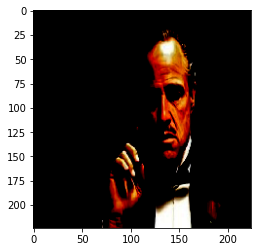

In [16]:
from matplotlib import pyplot
n = 10
print(X_train[n])
pyplot.imshow(X_train[n])

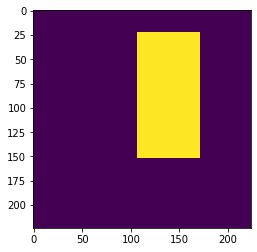

In [0]:
pyplot.imshow(masks[n])

## Create the model (10 marks)
- Add MobileNet as model with below parameter values
  - input_shape: IMAGE_HEIGHT, IMAGE_WIDTH, 3
  - include_top: False
  - alpha: 1.0
  - weights: "imagenet"
- Add UNET architecture layers
  - This is the trickiest part of the project, you need to research and implement it correctly

In [0]:

def create_model(trainable=True):
    model = MobileNet(input_shape=[IMAGE_HEIGHT, IMAGE_WIDTH,3],include_top=False,alpha=1, weights="imagenet")
    for layer in model.layers:
        layer.trainable = trainable

    upsample28 = model.get_layer('conv_pw_5_relu').output
    upsample14 = model.get_layer('conv_pw_11_relu').output
    upsample7 = model.get_layer('conv_pw_13_relu').output
    upsample56 = model.get_layer('conv_pw_3_relu').output
    upsample112 = model.get_layer('conv_pw_1_relu').output
    upsample224 = model.layers[0].output
  
    x = model.layers[-1].output
    x = Concatenate()([UpSampling2D()(upsample7),upsample14])
    x = Concatenate()([UpSampling2D()(x),upsample28])
    x = Concatenate()([UpSampling2D()(x),upsample56])
    x = Concatenate()([UpSampling2D()(x),upsample112])
    x = Concatenate()([UpSampling2D()(x),upsample224])
    x = Conv2D(1, kernel_size=(1,1), activation="sigmoid")(x)
    x = Reshape((224,224))(x)

    model = Model(inputs=model.inputs, outputs=[x])
    return model

### Call the create_model function

In [9]:
# Give trainable=False as argument, if you want to freeze lower layers for fast training (but low accuracy)
model = create_model()

# Print summary
model.summary()

17227776/17225924 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 32) 864         conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 32) 128         conv1[0][0]                      
_____________________________

### Define dice coefficient function (5 marks)
- Create a function to calculate dice coefficient


In [0]:
def dice_coefficient(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)

    return numerator / (denominator + tf.keras.backend.epsilon())

### Define loss

In [0]:
def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - log(dice_coefficient(y_true, y_pred) + epsilon())

### Compile the model (5 marks)
- Complie the model using below parameters
  - loss: use the loss function defined above
  - optimizers: use Adam optimizer
  - metrics: use dice_coefficient function defined above

In [0]:
optimizer = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss=loss, optimizer=optimizer, metrics=[dice_coefficient])

### Define checkpoint and earlystopping

In [13]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
checkpoint = ModelCheckpoint("model-{loss:.2f}.h5", monitor="loss", verbose=1, save_best_only=True,
                             save_weights_only=True, mode="min", period=1)
stop = EarlyStopping(monitor="loss", patience=5, mode="min")
reduce_lr = ReduceLROnPlateau(monitor="loss", factor=0.2, patience=5, min_lr=1e-6, verbose=1, mode="min")

### Fit the model (5 marks)
- Fit the model using below parameters
  - epochs: you can decide
  - batch_size: 1
  - callbacks: checkpoint, reduce_lr, stop

In [0]:
train=X_train[:300]
val=X_train[300:]
train_mask=masks[:300]
val_mask=masks[300:]

In [15]:
model.fit(train,train_mask,
                    epochs=10,
                    validation_data=[val,val_mask],
                    callbacks=[checkpoint, reduce_lr, stop],
                    workers=1,
                    use_multiprocessing=False,
                    batch_size=1,
                    verbose=1)

Epoch 1/10
299/300 [============================>.] - ETA: 0s - loss: 1.6094 - dice_coefficient: 0.4205
Epoch 00001: loss improved from inf to 1.60679, saving model to model-1.61.h5
300/300 [==============================] - 12s 41ms/step - loss: 1.6068 - dice_coefficient: 0.4209 - val_loss: 0.0000e+00 - val_dice_coefficient: 0.0000e+00 - lr: 1.0000e-04
Epoch 2/10
299/300 [============================>.] - ETA: 0s - loss: 0.8156 - dice_coefficient: 0.6051
Epoch 00002: loss improved from 1.60679 to 0.81402, saving model to model-0.81.h5
300/300 [==============================] - 12s 40ms/step - loss: 0.8140 - dice_coefficient: 0.6055 - val_loss: 0.0000e+00 - val_dice_coefficient: 0.0000e+00 - lr: 1.0000e-04
Epoch 3/10
299/300 [============================>.] - ETA: 0s - loss: 0.6390 - dice_coefficient: 0.6714
Epoch 00003: loss improved from 0.81402 to 0.63838, saving model to model-0.64.h5
300/300 [==============================] - 13s 43ms/step - loss: 0.6384 - dice_coefficient: 0.6714

### Get the predicted mask for a sample image   (5 marks)

In [0]:
n = 10
sample_image = X_train[n]

WEIGHTS_FILE = "model-0.41.h5"
THRESHOLD = 0.8
EPSILON = 0.02

model = create_model()
model.load_weights(WEIGHTS_FILE)

image = cv2.resize(sample_image, (IMAGE_WIDTH, IMAGE_HEIGHT))
#image = preprocess_input(image)

region = model.predict(x=np.array([image]))[0]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


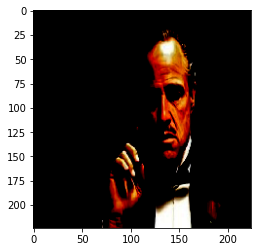

In [17]:
image = cv2.resize(sample_image, (IMAGE_WIDTH, IMAGE_HEIGHT))
plt.imshow(image)
plt.show()

-0.9843137264251709

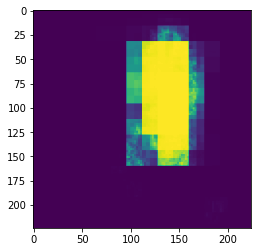

In [18]:
plt.imshow(region)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


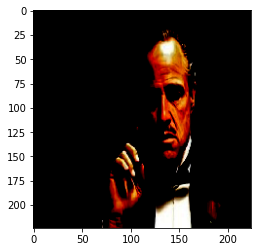

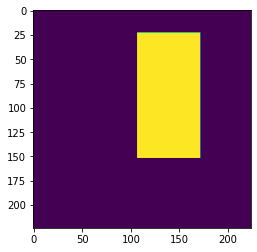

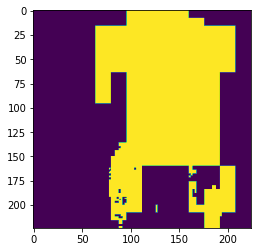

In [19]:
# Original image , Train mask and predicted mask
plt.imshow(sample_image)
plt.show()
plt.imshow(train_mask[n])
plt.show()
region = cv2.resize(1.0*(region > 0.0005),(IMAGE_WIDTH,IMAGE_HEIGHT))
plt.imshow(region)
plt.show()

### Impose the mask on the image (5 marks)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(array([  0,   0,   0, ..., 223, 223, 223]), array([ 96,  97,  98, ..., 189, 190, 191]))
AxesSubplot(0.125,0.125;0.775x0.755)
Rectangle(xy=(64, 0), width=143, height=223, angle=0)


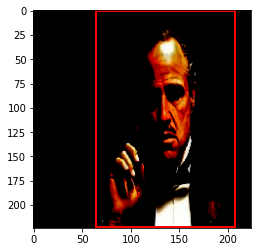

In [20]:
import matplotlib.patches as patches

indices = np.where(region > 0)
print(indices)
y2=np.max(indices[0])
y=np.min(indices[0])
x=np.min(indices[1])
x2=np.max(indices[1])

fig,ax=plt.subplots(1)

ax.imshow(sample_image)
print(ax)
rec = patches.Rectangle((x,y),x2-x,y2-y,linewidth=2,edgecolor='r',facecolor='none')
print(rec)
ax.add_patch(rec)
plt.show()

# The predicted mask is not a perfect one. Model needs to be retrained with more data.
# And i was not able to impose seperate rectangles for multiple faces. Please help me with code for that.